## Relaxation on Perovskite Structures using Perovs-IAP
This notebook would aid you in loading our fine-tuned M3GNET model Perovs-IAP, and relax a perovskite structure from the Materials Project. We also plot the relaxation trajectory which shows how the relaxation proceeds.


In [1]:
!pip install matgl -q

In [2]:
!pip uninstall dgl -y -q
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/repo.html -q

In [3]:
!pip install mp_api pymatgen ase -q

In [4]:
#ignore warnings command
import warnings
warnings.filterwarnings('ignore')

In [5]:
from mp_api.client import MPRester
import ast
from matgl import load_model
from matgl.ext.ase import Relaxer
from pymatgen.core import Structure

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


First, let's get a perovskite structure from the Materials Project, you would need your API-key for this. Make sure to get a perovskite structure to obtain accurate results.

In [6]:
API_KEY = "9J76AeTI0TGu0SUAJS0BafOasktJ2CzB" #get your API key from https://next-gen.materialsproject.org/api
with MPRester(API_KEY) as mpr:
    # Get a perovskite structure from Materials Project
    structure = mpr.get_structure_by_material_id("mp-540839", conventional_unit_cell=True)  #Orthorhombic CsPbI3, you can use whatever you like
    structure.to("POSCAR", fmt="poscar")

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Let us load the structure, and the model, and start the relaxation.

Similiar to a standard DFT, you can adjust whether or not to relax the cell, or change the force tolerance.

In [7]:
!git clone https://github.com/maitreyo18/Fine-tuned-Perovs-IAP-for-Unified-Perovskite-Structure-Optimization.git

Cloning into 'Fine-tuned-Perovs-IAP-for-Unified-Perovskite-Structure-Optimization'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 1.04 MiB | 2.84 MiB/s, done.


In [8]:
struct = Structure.from_file("POSCAR")
pot = load_model("Fine-tuned-Perovs-IAP-for-Unified-Perovskite-Structure-Optimization/Perovs-IAP_finetuned_bulk+defect+surface_2025_PES")
relaxer = Relaxer(pot, relax_cell=False)  # Set relax_cell to True if you want to relax the cell parameters

In [9]:
relaxed_struct = relaxer.relax(struct, fmax=0.001, steps=100)

Final Energy: -55.6254 eV
Final Force Magnitude: 0.0033 eV/Angstrom
Energy Difference per Atom: -0.0189 eV/atom


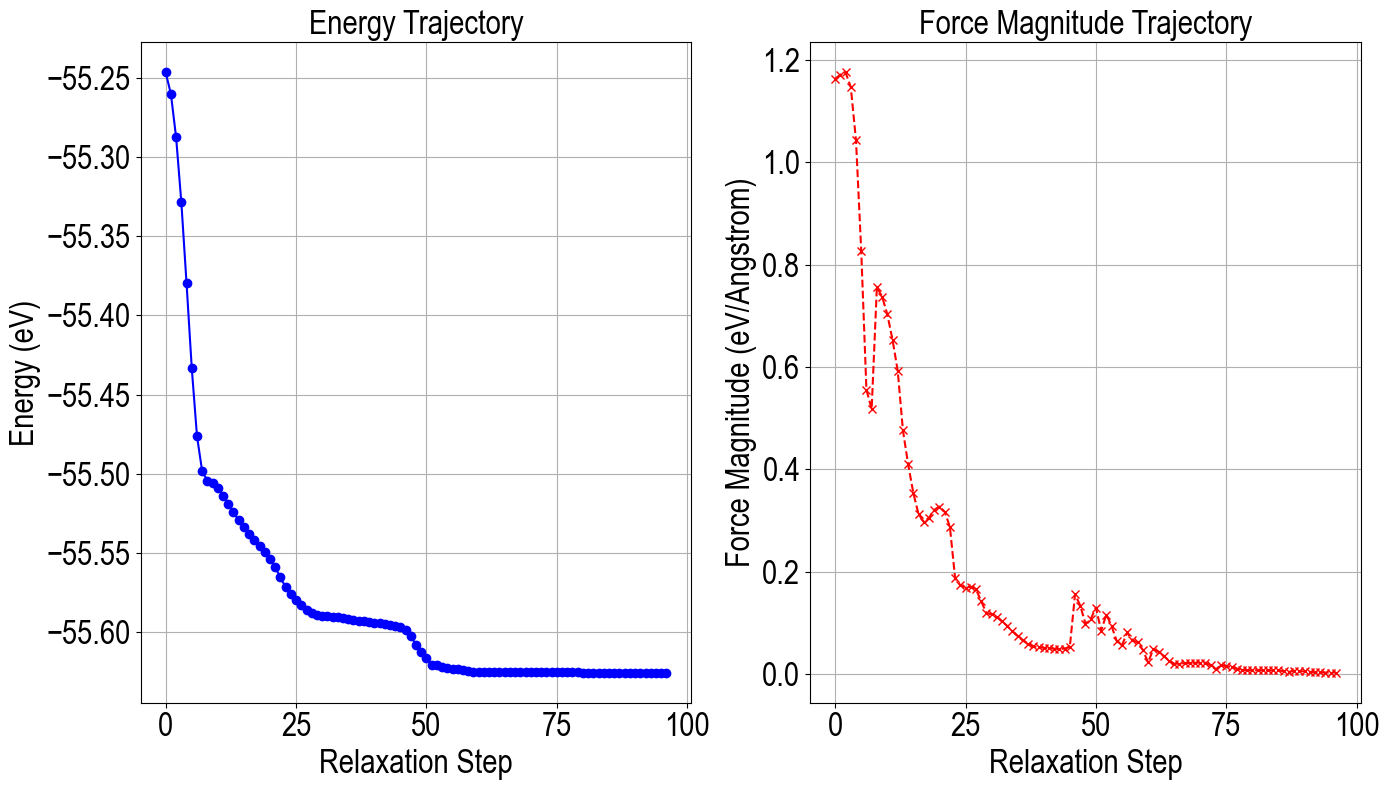

In [12]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Set font style to Arial Narrow using the uploaded file
font_path = '/content/arialnarrow.ttf'
try:
    # Add the font to Matplotlib's font manager
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'Arial Narrow'
except Exception as e:
    print(f"Could not set Arial Narrow font: {e}")
    print("Using default font.")
    # Fallback to a sans-serif font if Arial Narrow is not available
    plt.rcParams['font.family'] = 'sans-serif'


# Set large font sizes
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['figure.titlesize'] = 24

# Plot the trajectory side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 8)) # Create a figure with 1 row and 2 columns

steps = range(len(relaxed_struct['trajectory'].energies))
energies = relaxed_struct['trajectory'].energies
forces = relaxed_struct['trajectory'].forces
force_magnitudes = [sum(f**2 for f in step_forces.flatten())**0.5 for step_forces in forces]

# Print final energy and force magnitude
print(f"Final Energy: {energies[-1]:.4f} eV")
print(f"Final Force Magnitude: {force_magnitudes[-1]:.4f} eV/Angstrom")

# Calculate and print energy difference per atom
initial_energy = energies[0]
final_energy = energies[-1]
num_atoms = len(relaxed_struct['final_structure'])
energy_difference_per_atom = (final_energy - initial_energy) / num_atoms
print(f"Energy Difference per Atom: {energy_difference_per_atom:.4f} eV/atom")


# Plot Energy Trajectory in the left subplot
axes[0].plot(steps, energies, marker='o', linestyle='-', color='blue')
axes[0].set_xlabel('Relaxation Step')
axes[0].set_ylabel('Energy (eV)')
axes[0].set_title('Energy Trajectory')
axes[0].grid(True)

# Plot Force Magnitude Trajectory in the right subplot
axes[1].plot(steps, force_magnitudes, marker='x', linestyle='--', color='red')
axes[1].set_xlabel('Relaxation Step')
axes[1].set_ylabel('Force Magnitude (eV/Angstrom)')
axes[1].set_title('Force Magnitude Trajectory')
axes[1].grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [13]:
relaxed_struct['final_structure'].to("POSCAR_relaxed", fmt="poscar")

'Cs4 Pb4 I12\n1.0\n   4.8471416400000003    0.0000000000000000    0.0000000000000003\n   0.0000000000000017   10.6504466299999994    0.0000000000000007\n   0.0000000000000000    0.0000000000000000   18.0311992699999983\nCs Pb I\n4 4 12\ndirect\n   0.7499964423846198    0.0754588473287940    0.6655655484556394 Cs\n   0.2500015441183481    0.9245440203095803    0.3344342906425327 Cs\n   0.7500006055360618    0.5754564004127670    0.8344354841459047 Cs\n   0.2500021339650937    0.4245408038132881    0.1655656228686064 Cs\n   0.2499957423070634    0.1623382388764488    0.9266556394404316 Pb\n   0.7499943662442839    0.8376582282183664    0.0733427898002858 Pb\n   0.2500042907657086    0.6623438116800621    0.5733431279053529 Pb\n   0.7500013490473746    0.3376638577495929    0.4266566714116372 Pb\n   0.7500036910108893    0.3177349558129848    0.0035797212887194 I\n   0.2500016251244046    0.6822578982964347    0.9964201611717866 I\n   0.7500006249403564    0.8177425680611253    0.49642043